# IMPORT LIBRARIES

In [2]:
from PIL import Image
from random import random, randint, shuffle
from math import sqrt
from kNN import kNN
from sklearn.metrics import confusion_matrix
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# LOAD AND LABEL IMAGE FILES

In [3]:
path = os.path.join('C:/Users/Blssm/Desktop/ML_Project/sorted_cats_dogs','*g')
files = glob.glob(path) # 2000 pictures of cats followed by 2000 pictures of dogs

# Define the total number of loaded files for each class
n_cats = 500
n_dogs = 500
n_data = n_cats + n_dogs

# Build the labeled data list
data = []

for f in files[:n_cats]:
    img = Image.open(f)
    img = img.resize((500,500))
    img = img.convert('L')
    data.append([img,'cat'])

for f in files[2000:2000+n_dogs]:
    img = Image.open(f)
    img = img.resize((500,500))
    img = img.convert('L')
    data.append([img,'dog'])
    
shuffle(data,random)

In [4]:
print('Exemple of data : ', data[0])

Exemple of data :  [<PIL.Image.Image image mode=L size=500x500 at 0x19020696088>, 'cat']


# DISPLAY FEW EXAMPLES OF IMAGES

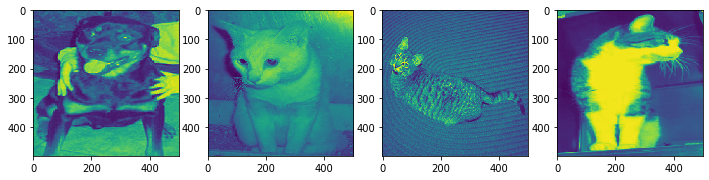

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(12, 10))
axs = axs.ravel()

axs[0].imshow(data[randint(0,n_data)][0])
axs[1].imshow(data[randint(0,n_data)][0])
axs[2].imshow(data[randint(0,n_data)][0])
axs[3].imshow(data[randint(0,n_data)][0])

# SEPARATE TRAINING AND TEST SETS FROM DATA

In [6]:
p_train = 0.7 # percentage of data used for the training task
n_train = int(p_train * n_data)
n_test = n_data - n_train

train_images = []
train_labels = []

for d in data[:n_train]:
    train_images.append(d[0])
    train_labels.append(d[1])
     
test_images = []
test_labels = []
        
for d in data[n_train:]:
    test_images.append(d[0])
    test_labels.append(d[1])

In [7]:
print(n_train)
print(n_test)

700
300


# FROM IMAGES TO MATRIXES...

In [8]:
train_data = [np.array(img) for img in train_images]
test_data = [np.array(img) for img in test_images]

# TRAIN DATA PROCESSING : IMPCA METHOD

In [9]:
A_mean = sum(A for A in train_data) / n_train

Gt = sum((A-A_mean).T@(A-A_mean) for A in train_data) / n_train

eigval,eigvect = np.linalg.eig(Gt)
idx = eigval.argsort()[::-1]
eigval = eigval[idx]
eigvect = eigvect[:,idx]

k = 2 # number of principal components retained
PC = eigvect[:,0:k] 

temp1 = [A@PC for A in train_data]
temp2 = [A.T for A in temp1]
dim = temp2[0].shape
new_train_data = [np.reshape(A, dim[0]*dim[1]) for A in temp2]

In [10]:
new_train_data = np.array(new_train_data)
new_train_data.shape # (n_train , size_image * nb_PC)

(700, 1000)

# TEST DATA PROCESSING : IMPCA METHOD

In [11]:
temp1 = [A@PC for A in test_data]
temp2 = [A.T for A in temp1]
dim = temp2[0].shape
new_test_data = [np.reshape(A, dim[0]*dim[1]) for A in temp2]

In [12]:
new_test_data = np.array(new_test_data)
new_test_data.shape # (n_test , size_image * nb_PC)

(300, 1000)

# PREDICTION : KNN METHOD

In [13]:
def accuracy_for_any_k(k):
    # Run kNN algorithm
    predicted_labels = [''] * n_test

    for i in range(n_test):
        predicted_labels[i] = kNN(k, new_train_data, train_labels, new_test_data[i,:])

    # Calculate accuracy
    correct = 0

    for i in range(n_test):
        if predicted_labels[i] == test_labels[i]:
            correct += 1

    accuracy = correct/float(n_test)
    return(accuracy)

In [14]:
# Rule of thumb for initial guess
k_thumb = int(sqrt(n_train))
print('Rule of thumb k : ',k_thumb)
print('Rule of thumb accuracy : ',accuracy_for_any_k(k_thumb))

Rule of thumb k :  26
Rule of thumb accuracy :  0.5766666666666667


Local maximum accuracy k :  26
Local maximum accuracy :  0.5766666666666667


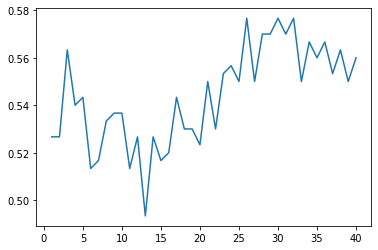

In [16]:
# Identify a k of local maximum accuracy
nb_neighbors = [k for k in range(1,41)] # upper limit should be above k_thumb AND below n_train 
accuracies = [accuracy_for_any_k(k) for k in nb_neighbors]

k_max = accuracies.index(max(accuracies)) + 1

print('Local maximum accuracy k : ',k_max)
print('Local maximum accuracy : ',max(accuracies))
plt.plot(nb_neighbors,accuracies)

# CONFUSION MATRIX

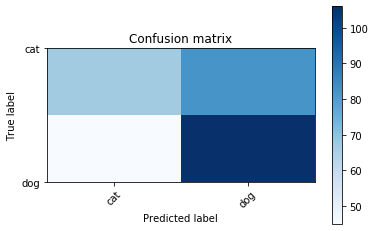

In [17]:
predicted_labels = [''] * n_test

for i in range(n_test):
    predicted_labels[i] = kNN(k_max, new_train_data, train_labels, new_test_data[i,:])

labels = ["cat", "dog"]
C = confusion_matrix(test_labels, predicted_labels, labels=labels)

plt.figure()

plt.imshow(C, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()

plt.show()